## Import/load

In [3]:

import cv2
import matplotlib.pyplot as plt
import json
import numpy as np
import yaml
import os
from tqdm import tqdm
import pandas as pd
from utils.visualizer import Visualizer
from utils.keypoints_tools import *
from PIL import Image
from sklearn.cluster import KMeans
from itertools import combinations
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS, Isomap
from ast import literal_eval
import umap
import plotly.express as px


import pandas as pd

In [2]:
import os

# Pobierz bieżący katalog roboczy
biezacy_katalog = os.getcwd()

# Uzyskaj ścieżkę do poprzedniego folderu
poprzedni_folder = os.path.dirname(biezacy_katalog)

# Cofnij się do poprzedniego folderu
os.chdir(poprzedni_folder)

# Wydrukuj nowy bieżący katalog roboczy (opcjonalnie)
print("Bieżący katalog roboczy:", os.getcwd())


Bieżący katalog roboczy: c:\Program Files (x86)\Common Files\projekt_nw


In [4]:
config_path = os.path.join('configs/1_per.yaml')
# config_path = os.path.join('config.yaml')

with open(config_path) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    
path_keypoints_3d_1person = cfg['path_keypoints_3d_1person']
connections_3d = cfg['human36_connections']
useless_points_3d = cfg['human36_head_points']
base_connestion_3d = cfg['human36_base_connestion']
angles_3d = cfg['human36_angles']

path_keypoints_2d_1person = cfg['path_keypoints_2d_1person']
connections_2d = cfg['coco_connections']
useless_points_2d = cfg['coco_head_points']
base_connestion_2d = cfg['coco_base_connestion']
angles_2d = cfg['coco_angles']

path_images = cfg['path_image']
path_popular = cfg['path_metadata_popular']
data_path_map = cfg['path_mapping']
path_people_mapping = cfg['path_people_mapping']

In [5]:
# Lista, która będzie przechowywać dane z poszczególnych plików
data_list = []

# Iteracja przez pliki w folderze
for filename in tqdm(os.listdir(path_popular), desc="Wczytywanie plików .info"):
    if filename.endswith('.info'):
        file_path = os.path.join(path_popular, filename)

        # Wczytanie pliku JSON i dodanie do listy
        with open(file_path, 'r', encoding='utf-8') as file:
            json_data = json.load(file)
        
        # Dodanie słownika do listy
        data_list.append(json_data)

# Utworzenie DataFrame z listy słowników
popular_df = pd.DataFrame(data_list)

# czy to pomaga w notebookach?
del data_list


Wczytywanie plików .info: 100%|██████████| 97481/97481 [10:08<00:00, 160.08it/s]


In [6]:
def get_photo_map_from_keypoints(filename):
    id = filename.split('-')[1] 
    return id

In [7]:
mapping_df = pd.read_csv(data_path_map, sep='\t')
#  zeby można było zrobić explode, typuj jako liste
mapping_df['Image_file_name'] = mapping_df['Image_file_name'].apply(literal_eval)
mapping_df = pd.merge(mapping_df['Image_file_name'].explode(), mapping_df[['JSON_PostMetadata_file_name']], left_index=True, right_index=True)
mapping_df = mapping_df.reset_index(drop=True)

In [8]:
df_people = pd.read_csv(path_people_mapping, sep='\t', names=['filename', 'people'])

In [9]:
df_people['filename_map'] = df_people['filename'].apply(get_photo_map_from_keypoints)

## Merge df

In [10]:
marged_df = pd.merge(popular_df, mapping_df, left_on='post_map', right_on='JSON_PostMetadata_file_name')
marged_df = pd.merge(marged_df, df_people, left_on='Image_file_name', right_on='filename_map')

In [11]:
marged_df[marged_df['people']==1]

,post_map,filename_x,likes,Username,#Followers,log_likes,log_followers,engagement_rate,mean_likes,std_likes,...,popular_engagement_median,popular_z_score_mean,popular_z_score_median,predicted_log_likes,popular_regression,Image_file_name,JSON_PostMetadata_file_name,filename_y,people,filename_map
35,1709004344122507373.info,21andhungry-1709004344122507373.info,411,21andhungry,2716,6.018593,7.906915,15.132548,247.494915,57.141719,...,True,True,True,4.410085,True,1709004344122507373.jpg,1709004344122507373.info,21andhungry-1709004344122507373.jpg,1,1709004344122507373.jpg
59,1732757448640221464.info,21andhungry-1732757448640221464.info,287,21andhungry,2716,5.659482,7.906915,10.567010,247.494915,57.141719,...,True,True,True,4.410085,True,1732757448640221464.jpg,1732757448640221464.info,21andhungry-1732757448640221464.jpg,1,1732757448640221464.jpg
66,1737839725787390113.info,21andhungry-1737839725787390113.info,321,21andhungry,2716,5.771441,7.906915,11.818851,247.494915,57.141719,...,True,True,True,4.410085,True,1737839725787390113.jpg,1737839725787390113.info,21andhungry-1737839725787390113.jpg,1,1737839725787390113.jpg
74,1743867257748275198.info,21andhungry-1743867257748275198.info,281,21andhungry,2716,5.638355,7.906915,10.346097,247.494915,57.141719,...,True,True,True,4.410085,True,1743867257748275198.jpg,1743867257748275198.info,21andhungry-1743867257748275198.jpg,1,1743867257748275198.jpg
80,1748873849862474760.info,21andhungry-1748873849862474760.info,295,21andhungry,2716,5.686975,7.906915,10.861561,247.494915,57.141719,...,True,True,True,4.410085,True,1748873849862474760.jpg,1748873849862474760.info,21andhungry-1748873849862474760.jpg,1,1748873849862474760.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119297,2030967648977663153.info,___noangel-2030967648977663153.info,3097,___noangel,24802,8.038189,10.118680,12.486896,2449.461279,874.437541,...,True,True,True,6.466534,True,2030967645857107118.jpg,2030967648977663153.info,___noangel-2030967645857107118.jpg,1,2030967645857107118.jpg
119298,2030967648977663153.info,___noangel-2030967648977663153.info,3097,___noangel,24802,8.038189,10.118680,12.486896,2449.461279,874.437541,...,True,True,True,6.466534,True,2030967645873848453.jpg,2030967648977663153.info,___noangel-2030967645873848453.jpg,1,2030967645873848453.jpg
119299,2031614124434951959.info,___noangel-2031614124434951959.info,2595,___noangel,24802,7.861342,10.118680,10.462866,2449.461279,874.437541,...,True,True,True,6.466534,True,2031614124434951959.jpg,2031614124434951959.info,___noangel-2031614124434951959.jpg,1,2031614124434951959.jpg
119300,2033752253400951154.info,___noangel-2033752253400951154.info,3322,___noangel,24802,8.108322,10.118680,13.394081,2449.461279,874.437541,...,True,True,True,6.466534,True,2033752243166917461.jpg,2033752253400951154.info,___noangel-2033752243166917461.jpg,1,2033752243166917461.jpg


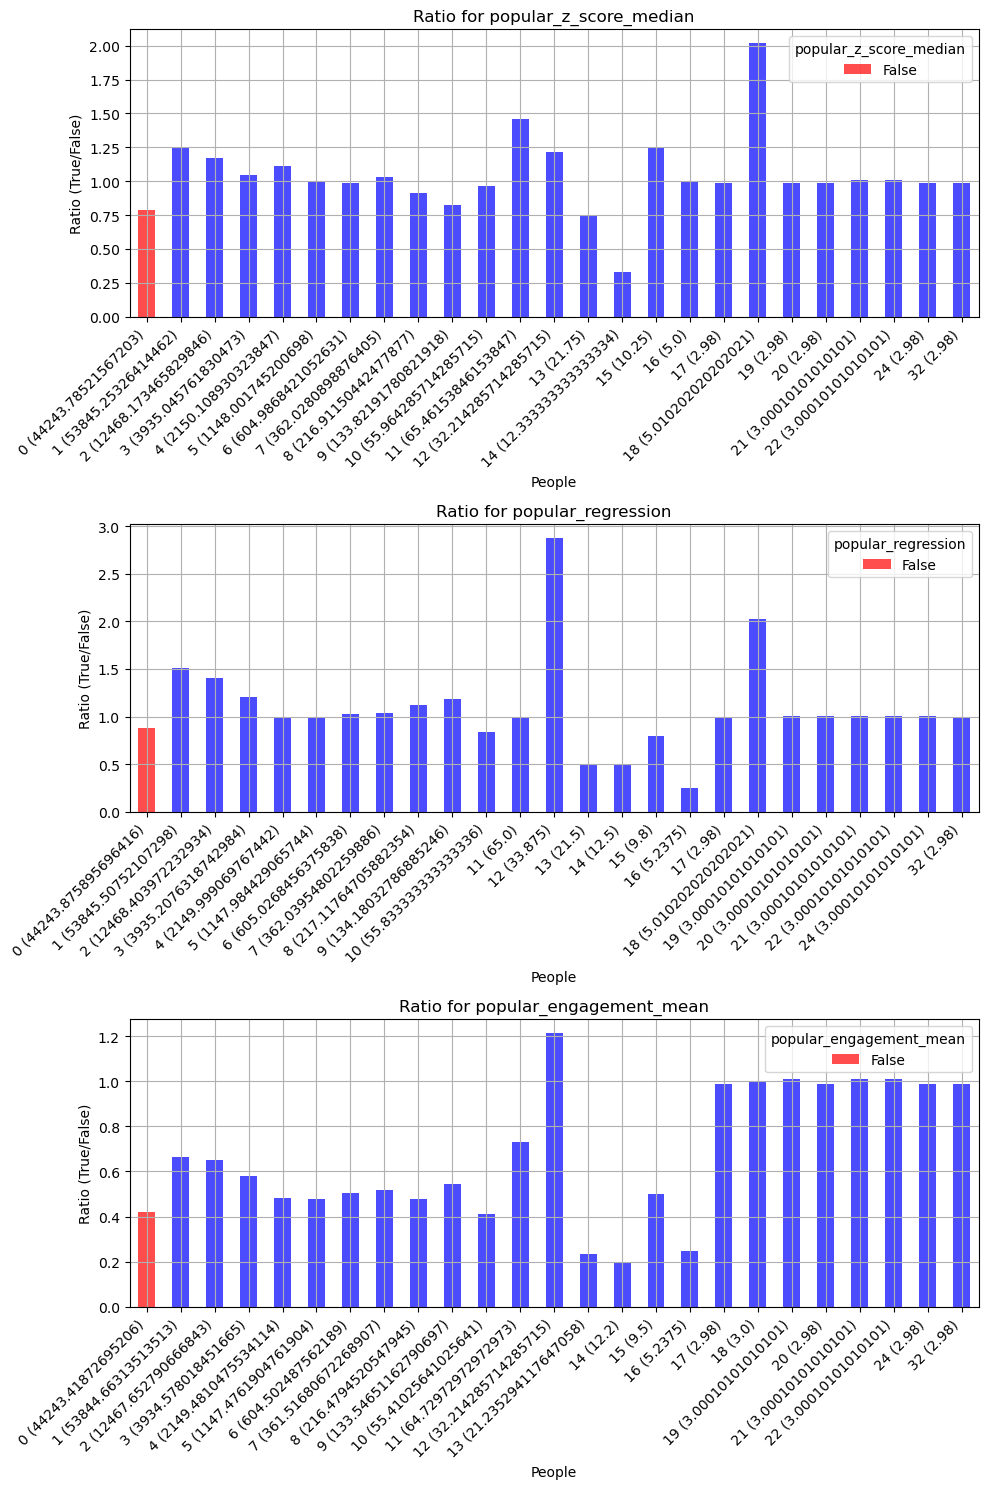

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Zakładam, że masz już wczytane dane i zdefiniowane zmienne popular_df oraz columns_list
columns_list = ['popular_z_score_median', 'popular_regression', 'popular_engagement_mean']
# Inicjalizacja wykresu
fig, axes = plt.subplots(nrows=len(columns_list), ncols=1, figsize=(10, 15))

for i, column in enumerate(columns_list):
    # Grupowanie danych wg 'people' i kolumny
    grouped_data = marged_df.groupby('people')[column].value_counts().unstack().fillna(0.99)
    
    # Obliczanie stosunku True do False
    grouped_data['Ratio'] = grouped_data[True] / grouped_data[False]
    
    # Tworzenie wykresu słupkowego dla każdej wartości 'labels'
    ax = axes[i]
    bar_colors = ['blue' if val else 'red' for val in grouped_data.index]
    bars = grouped_data['Ratio'].plot(kind='bar', ax=ax, color=bar_colors, alpha=0.7)
    
    # Dodawanie etykiet z liczbą zagregowanych wierszy na osi x
    labels = [f"{val} ({count})" for val, count in zip(grouped_data.index, grouped_data.sum(axis=1))]
    ax.set_xticklabels(labels, rotation=45, ha='right')
    
    # Dostosowanie etykiet
    ax.set_title(f'Ratio for {column}')
    ax.set_xlabel('People')
    ax.set_ylabel('Ratio (True/False)')
    ax.legend(['False', 'True'], title=column)
    ax.grid(True)

# Wyświetlanie wykresu
plt.tight_layout()
plt.show()


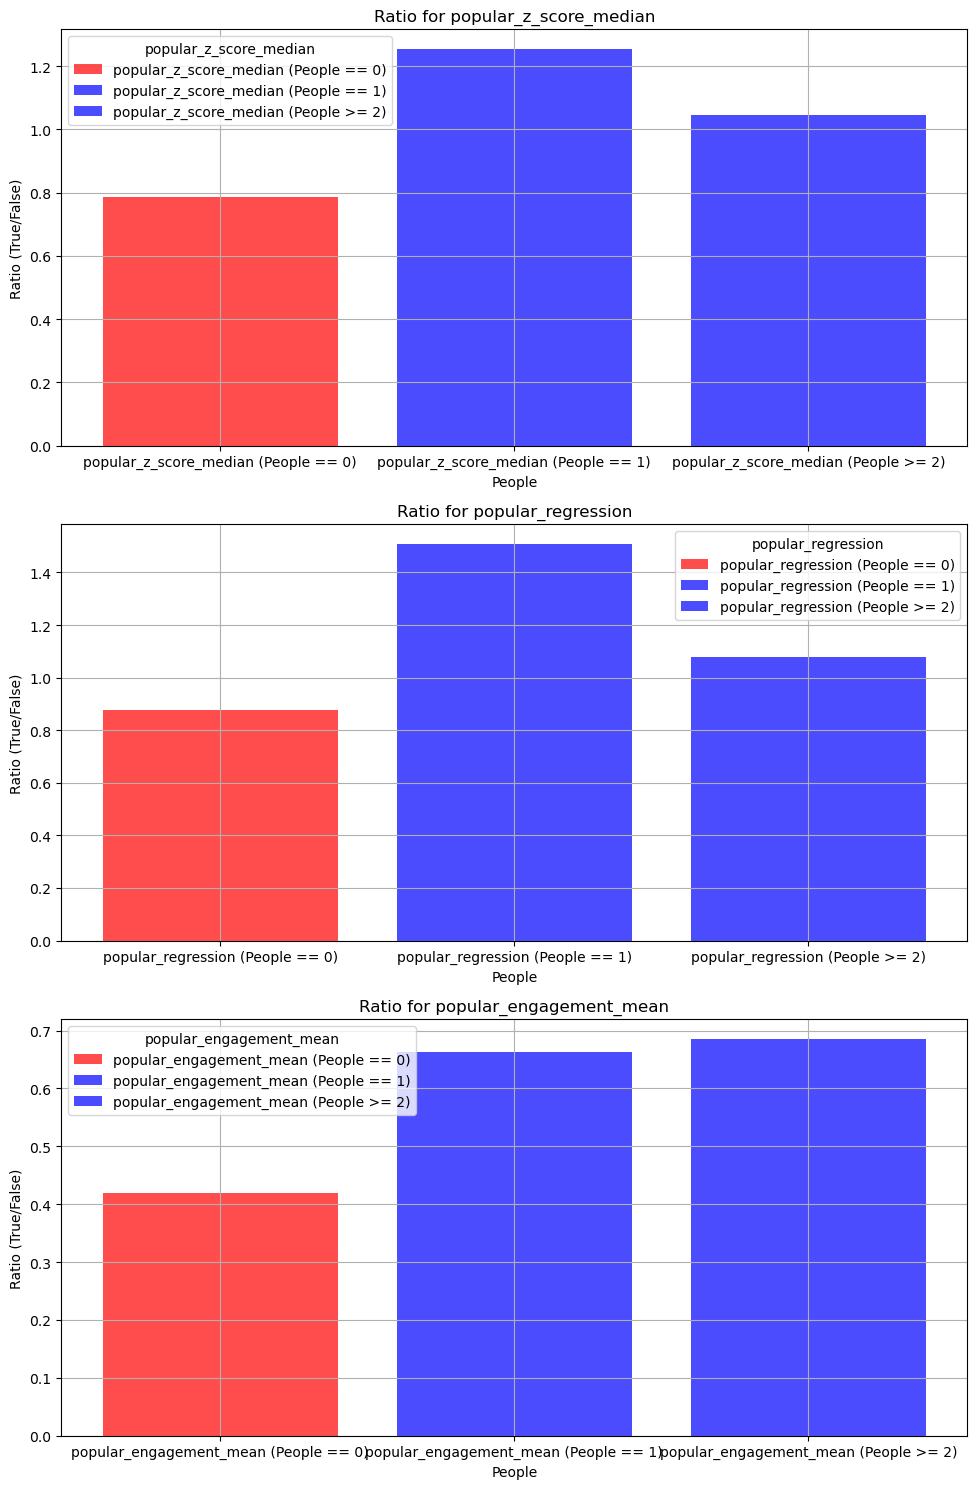

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Zakładam, że masz już wczytane dane i zdefiniowane zmienne popular_df oraz columns_list

# Inicjalizacja wykresu
fig, axes = plt.subplots(nrows=len(columns_list), ncols=1, figsize=(10, 15))

people_limit = 2 # Ustaw liczbę osób do wyświetlenia

for i, column in enumerate(columns_list):
    # Grupowanie danych wg 'people' i kolumny
    grouped_data = marged_df.groupby('people')[column].value_counts().unstack().fillna(0.99)
    
    # Obliczanie stosunku True do False
    grouped_data['Ratio'] = grouped_data[True] / grouped_data[False]
    
    # Tworzenie wykresu słupkowego dla każdej wartości 'labels'
    ax = axes[i]
    
    # Dynamiczne tworzenie słupków w zależności od people_limit
    for index in range(people_limit + 1):
        label = f'{column} (People == {index})' if index < people_limit else f'{column} (People >= {people_limit})'
        bar_color = 'blue' if index > 0 else 'red'  # True (niebieski) lub False (czerwony)
        bar_height = grouped_data.loc[index, 'Ratio'] if index < people_limit else grouped_data.loc[people_limit:, 'Ratio'].mean()
        
        ax.bar(index, bar_height, color=bar_color, alpha=0.7, label=label)

    # Ustawienia osi x
    ax.set_xticks(range(people_limit + 1))
    ax.set_xticklabels([f'{column} (People == {index})' for index in range(people_limit)] + [f'{column} (People >= {people_limit})'])
    
    # Dostosowanie etykiet
    ax.set_title(f'Ratio for {column}')
    ax.set_xlabel('People')
    ax.set_ylabel('Ratio (True/False)')
    ax.legend(title=column)
    ax.grid(True)

# Wyświetlanie wykresu
plt.tight_layout()
plt.show()


In [30]:
fig = go.Figure()

people_limit = 2  # Ustaw liczbę osób do wyświetlenia

# Grupowanie danych wg 'people' i kolumny
grouped_data = marged_df.groupby('people')['popular_regression'].value_counts().unstack().fillna(0.99)

# Obliczanie stosunku True do False
grouped_data['Ratio'] = grouped_data[True] / grouped_data[False]

# Dynamiczne tworzenie słupków w zależności od people_limit
for index in range(people_limit + 1):
    label = f'{index}' if index < people_limit else f'{people_limit}+'
    bar_color = '#A273FF' if index > 0 else '#A273FF'  # True (niebieski) lub False (czerwony)
    bar_height = grouped_data.loc[index, 'Ratio'] if index < people_limit else grouped_data.loc[people_limit:, 'Ratio'].mean()

    # Dodawanie słupków do wykresu
    fig.add_trace(
        go.Bar(
            x=[label],
            y=[bar_height],
            marker=dict(color=bar_color, opacity=0.7),
            textfont=dict(size=21),
        )
    )

fig.update_layout(
    xaxis_title='Liczba ludzi na zdjęciu',
    yaxis_title='Liczba popularnych / liczba niepopularnych postów',
    showlegend=False,
    legend=dict(
        x=0.02,
        y=0.98,
        traceorder='normal',
        orientation='h',
        font=dict(family='Arial, sans-serif', size=21, color='black'),  # Zwiększenie rozmiaru czcionki
        bgcolor='rgba(255, 255, 255, 0.6)',
        bordercolor='rgba(0, 0, 0, 0.1)',
        borderwidth=2
    ),
    height=900,
    width=1900, # Wysokość wykresu
    xaxis=dict(
        title_font=dict(size=29),  # Zwiększenie rozmiaru czcionki w podpisie osi x
        tickfont=dict(size=27)  # Zwiększenie rozmiaru czcionki w etykietach osi x
    ),
    yaxis=dict(
        title_font=dict(size=27),  # Zwiększenie rozmiaru czcionki w podpisie osi y
        tickfont=dict(size=27)  # Zwiększenie rozmiaru czcionki w etykietach osi y
    ),
    title=dict(
        text='Liczby ludzi na zdjęciu, a popularność',  # Tytuł
        font=dict(size=37)  # Zwiększenie rozmiaru czcionki w tytule
    )
)

# Wyświetlanie wykresu
fig.show()